In [7]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks.

In [6]:
!python -m pip install tqdm

    100% |████████████████████████████████| 51kB 17.6MB/s 
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [8]:
TRAIN_DIR = './train'
TEST_DIR = './test'
IMG_SIZE = 100
LR = 1e-5

# just so we remember which saved model is which, sizes must match
MODEL_NAME = 'rndorcap-{}-{}.model'.format(LR, '2conv-basic') 

In [9]:
def label_img(img):
    word_label = img.split('.')[-3]
    # conversion to one-hot array [rnd,cap]
    if word_label == 'rnd': return [1,0] # [much rnd, no cap]
    elif word_label == 'cap': return [0,1] # [no rnd, very cap]

In [46]:
def create_train_data():
    training_data = []
    ctr = 0
    
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
        ctr += 1
    print(f'{ctr} images added')
    
    shuffle(training_data)
    print('"training_data" has been shuffled')
    np.save('train_data.npy', training_data)
    return training_data

In [60]:
def process_test_data():
    testing_data = []
    ctr = 0
    
#     for img in tqdm(os.listdir(TEST_DIR)):
#         label = label_img(img)
#         path = os.path.join(TEST_DIR,img)
#         img_num = img.split('.')[0]
#         img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
#         img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
#         testing_data.append([np.array(img), img_num])
#         ctr += 1
    
    for img in tqdm(os.listdir(TEST_DIR)):
        if ".ipynb_checkpoints" not in str(img):
#             print('img:\n',img)
            label = label_img(img)
    #         print('label:\n',label)
            path = os.path.join(TEST_DIR,img)
#             print('path:\n',path)
            img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
            testing_data.append([np.array(img),np.array(label)])
    #         print('testing_data:\n',testing_data)
            ctr += 1
#             print('count: ', ctr)
    print(f'{ctr} images added')
        
    shuffle(testing_data)
    print('"testing_data" has been shuffled')
    np.save('test_data.npy', testing_data)
    return testing_data

In [12]:
train_data = create_train_data()

100%|██████████| 3000/3000 [00:03<00:00, 897.82it/s]


3000 images added
"training_data" has been shuffled


### Network with 6 layers

In [14]:
!python -m pip install tflearn

    100% |████████████████████████████████| 102kB 18.7MB/s 
  Running setup.py bdist_wheel for tflearn ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/d0/f6/69/0ef3ee395aac2e5d15d89efd29a9a216f3c27767b43b72c006
Successfully built tflearn
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [15]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


In [16]:
# We want to be saving our model after every session and reloading it if we have a saved version
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

In [17]:
# Grabbing some of the train data for validation
train = train_data[:-200]
validation = train_data[-200:]

In [20]:
# NOTE!!! --->> array[:,0] and array[:,1] did NOT work <---

# HERE! Separating features and labels:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

# For validation set:
val_x = np.array([i[0] for i in validation]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
val_y = [i[1] for i in validation]

### Training Model

In [21]:
model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': val_x}, {'targets': val_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 219  | total loss: 0.41839 | time: 5.421s
| Adam | epoch: 005 | loss: 0.41839 - acc: 0.9088 -- iter: 2752/2800
Training Step: 220  | total loss: 0.41579 | time: 6.551s
| Adam | epoch: 005 | loss: 0.41579 - acc: 0.9116 | val_loss: 0.40041 - val_acc: 0.9350 -- iter: 2800/2800
--


### Saving Model

In [22]:
!pip install joblib

    100% |████████████████████████████████| 286kB 23.2MB/s 
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
from joblib import dump, load
# dump(model, 'shape_model1.joblib')

In [29]:
model.save(MODEL_NAME)

INFO:tensorflow:/home/ec2-user/SageMaker/rndorcap-1e-05-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


In [ ]:
tensorboard --logdir=/home/ec2-user/SageMaker/log

In [28]:
pwd

'/home/ec2-user/SageMaker'

### Test data

In [61]:
# if you need to create the data:
test_data = process_test_data()
# if you already have some saved:
# test_data = np.load('test_data.npy')

100%|██████████| 1001/1001 [00:01<00:00, 962.66it/s]

1000 images added
"testing_data" has been shuffled


In [62]:
# NOTE!!! --->> array[:,0] and array[:,1] did NOT work <---
# HERE! Separating features and labels:
test_x = np.array([i[0] for i in test_data]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test_data]

### Predicting with Test data

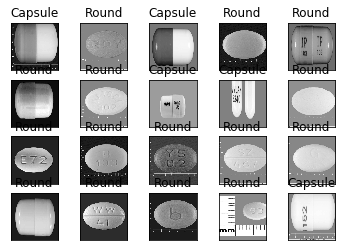

In [38]:
import matplotlib.pyplot as plt

fig=plt.figure()

for num,data in enumerate(test_data[-20:]):
    # rnd: [1,0]
    # cap: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(4,5,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Capsule'
    else: str_label='Round'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [75]:
predictions = model.predict(test_x)

In [78]:
pred_label = []
for prediction in predictions:
    if np.argmax(prediction) == 1: prediction='Capsule'
    else: prediction='Round'
    pred_label.append(prediction)

In [79]:
test_label= []
for label in test_y:
    if np.argmax(label) == 1: label='Capsule'
    else: label='Round'
    test_label.append(label)

In [90]:
import pandas as pd
df = pd.DataFrame(list(zip(test_label, pred_label)), 
               columns =['Real', 'Prediction'])

In [91]:
def accuracy_col(row):
    if row['Real'] == row['Prediction'] :
        return 1
    else:
        return 0

In [92]:
df['Accuracy'] = df.apply(lambda row: accuracy_col(row), axis=1)

In [93]:
df.head()

,Real,Prediction,Accuracy
0,Capsule,Capsule,1
1,Round,Round,1
2,Capsule,Capsule,1
3,Round,Round,1
4,Capsule,Capsule,1


In [94]:
df.Accuracy.value_counts()

1    926
0     74
Name: Accuracy, dtype: int64

In [96]:
print('Prediction accuracy:', 926/1000)

Prediction accuracy: 0.926
